# Merchant churned labeling

## About
The purpose of this project is to be a precourser of detecting merchants that may leave us. If we are able to detect if the leave **before** they leave, we can intercept them and hopefully change their mind.

This part revolves around creating a classifier that enriches our current data by labeling churned and not churned merchants in iceland, based on historical, well labeled, data.

In [2]:
#imports we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

sb.set_theme(style="white")

In [5]:
# load the data
active_merchants = pd.read_csv("../Data/transformed_active_v3.csv")
inactive_merchants = pd.read_csv("../Data/transformed_inactive.csv")

#removing columns we don't want in our training set and fil NaN with 0
df = pd.concat([active_merchants, inactive_merchants], ignore_index=True)
row_count, col_count = df.shape
df = df.drop(columns=['NMerchantID', 'avgNumTrx30', 'avgNumTrx60', 'avgNumTrx90', 'avgAmntTrx30', 'avgAmntTrx60', 'avgAmntTrx90'])
df.tail()

,SettlementCurrency,MerchantCountry,SettlementRule,MCCC,DaysSinceLastSettlement,MerchantBalanceISK,MerchantActive,avgNumTrxSinceLast30,avgNumTrxSinceLast60,avgNumTrxSinceLast90,avgAmntTrxSinceLast30,avgAmntTrxSinceLast60,avgAmntTrxSinceLast90
19693,CZK,CZE,Alþjsv. Mánaðarlegt uppgj.,5944,14.0,-4128.18,0,3.866667,3.200000,2.377778,22909.905983,19281.624875,14341.644017
19694,CZK,CZE,Alþjsv. Mánaðarlegt uppgj.,5944,14.0,-58127.76,0,0.033333,0.016667,0.011111,55.447600,27.723800,18.482533
19695,ISK,ISL,"Monthly, 18th-17th, pay 2nd",7372,1.0,-54509.00,0,0.233333,0.133333,0.466667,NaN,NaN,NaN
19696,EUR,SVK,"Weekly, Wed-Tues, delay 1w",4215,1.0,-1352.93,0,2.966667,3.033333,3.644444,4940.593587,4635.775222,5676.625893
19697,HUF,HUN,"Daily, delay 3d",5499,1.0,-6424.10,0,0.266667,0.233333,0.233333,3489.367408,2779.534574,2704.085660


SettlementCurrency: 0.00%
MerchantCountry: 0.00%
SettlementRule: 0.03%
MCCC: 0.00%
DaysSinceLastSettlement: 0.20%
MerchantBalanceISK: 0.04%
MerchantActive: 0.00%
avgNumTrxSinceLast30: 0.00%
avgNumTrxSinceLast60: 0.00%
avgNumTrxSinceLast90: 0.00%
avgAmntTrxSinceLast30: 0.09%
avgAmntTrxSinceLast60: 0.09%
avgAmntTrxSinceLast90: 0.10%


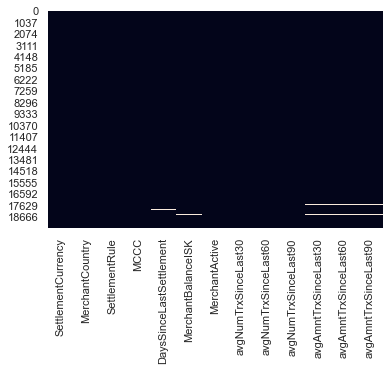

In [6]:
#show incomplete features
incomplete_features = []
for index, missingAmount in enumerate(df.isnull().sum()):
    percentage = (missingAmount / row_count)*100
    feature = df.columns[index]
    if percentage > 30:
        incomplete_features.append(feature)
    print(f"{feature}: {percentage:.2f}%")   

sb.heatmap(df.isnull(), cbar=False)
df = df.dropna()

## Correlation and analysis

<AxesSubplot:>

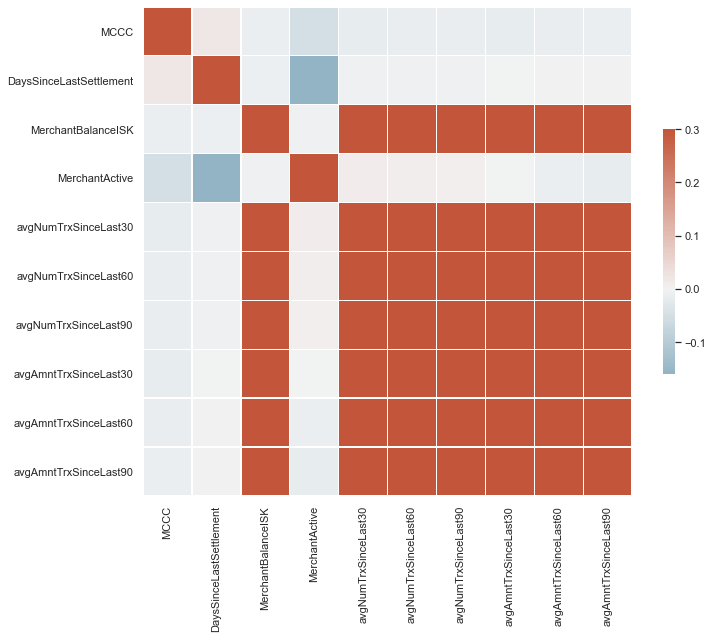

In [7]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As shown above, the largest corrilation between an active or an inactive merchant is the days since last settlement. Let's Fix our skewed data a bit and look at an undersampled dataset.

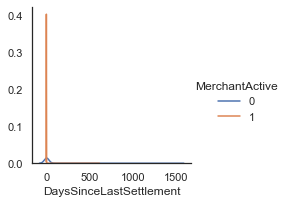

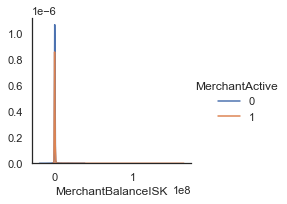

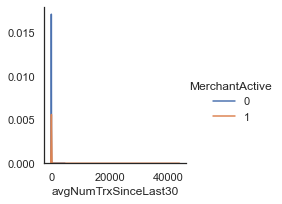

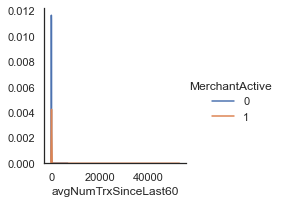

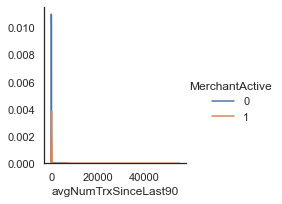

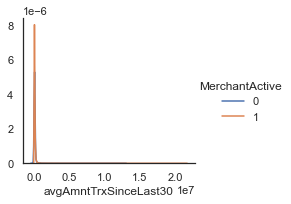

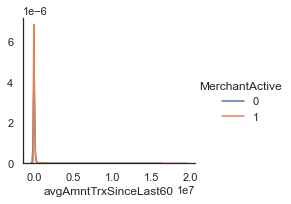

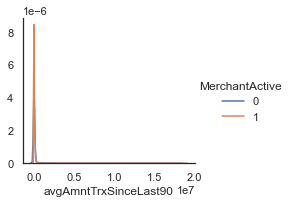

In [8]:
# correlation between humidity and RainTomrrow
cols = ['DaysSinceLastSettlement', 'MerchantBalanceISK', 'avgNumTrxSinceLast30', 'avgNumTrxSinceLast60', 'avgNumTrxSinceLast90', 'avgAmntTrxSinceLast30', 'avgAmntTrxSinceLast60', 'avgAmntTrxSinceLast90']
for column in cols:
    try:
        sb.FacetGrid(df, hue="MerchantActive").map(sb.kdeplot, column).add_legend()
    except:
        continue

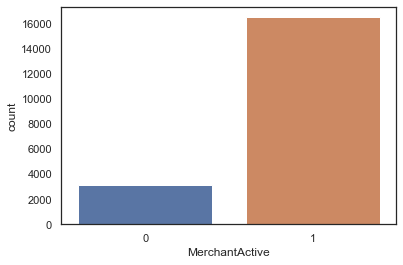

In [9]:
ax = sb.countplot(x="MerchantActive", data=df)

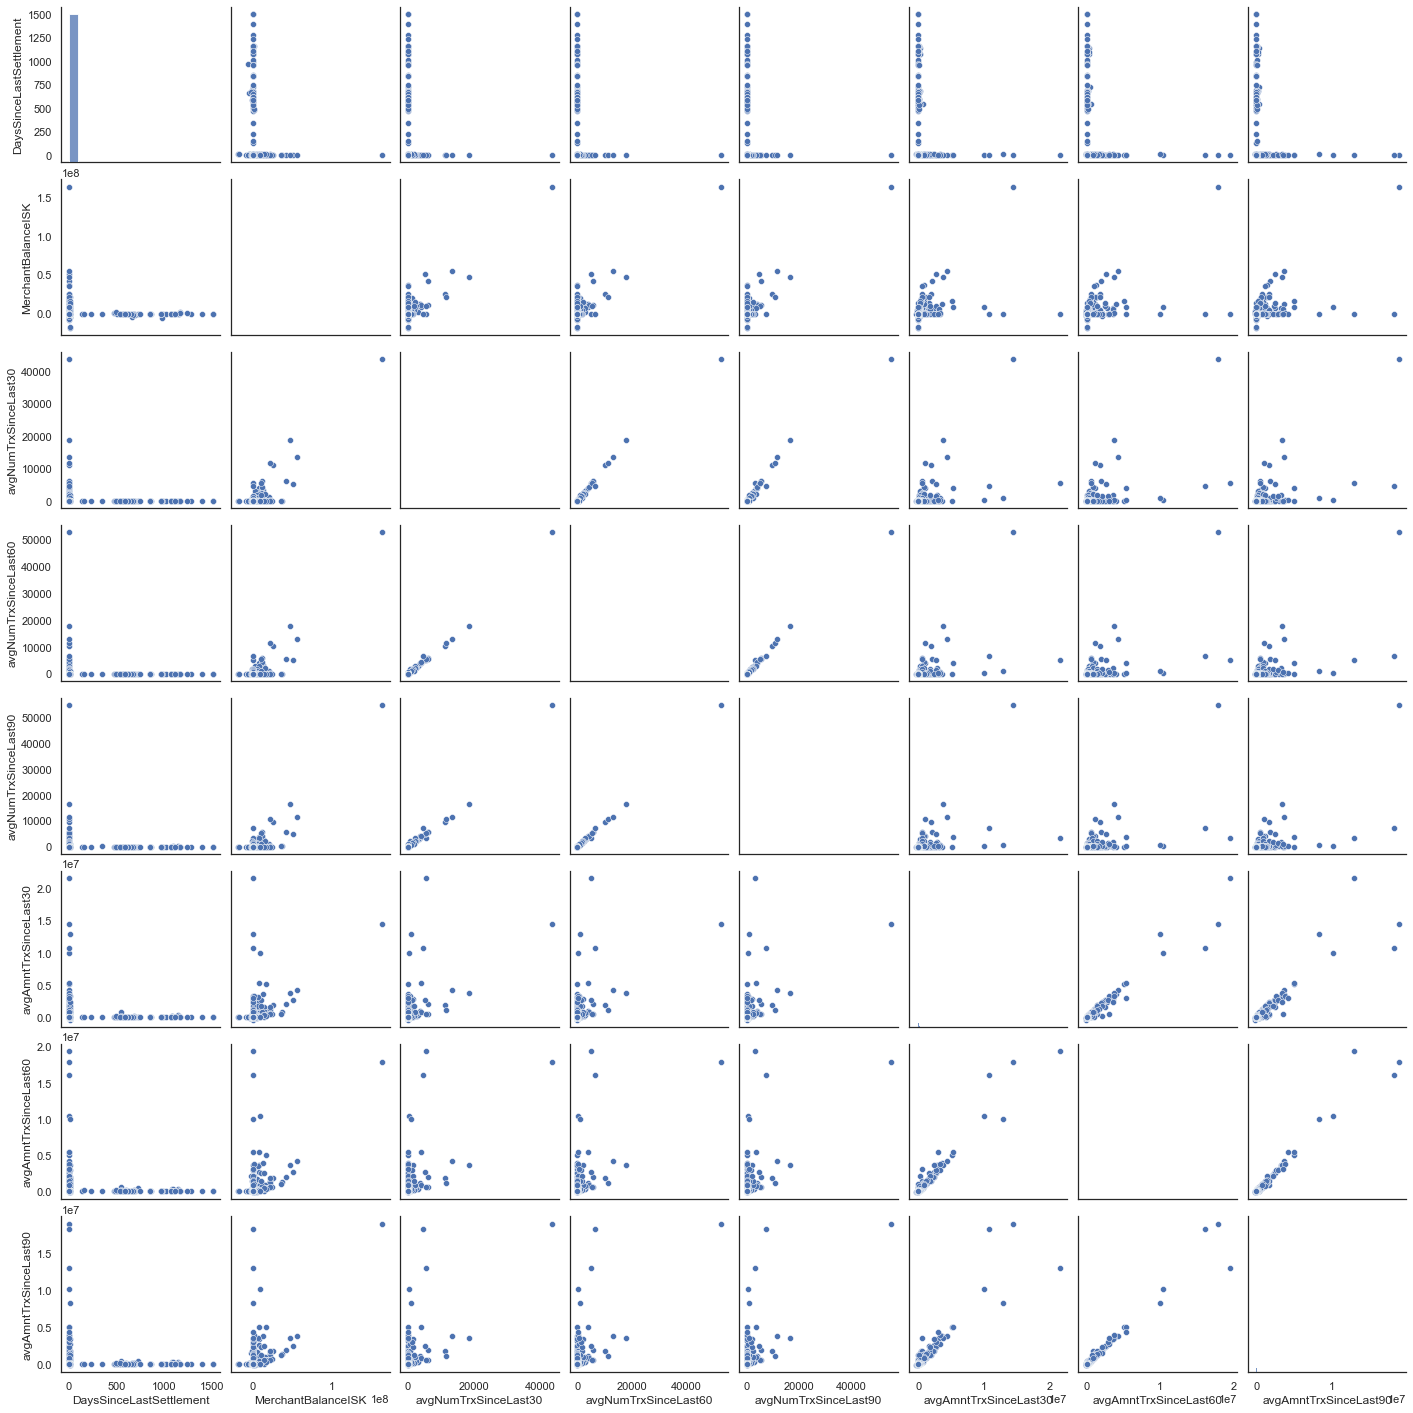

In [11]:
sb.pairplot(df.drop(columns=['MCCC', 'MerchantActive']))

# Model Training

In [41]:
X = df.drop(['MerchantActive'], axis=1)
y = df['MerchantActive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_features = ['DaysSinceLastSettlement', 'MerchantBalanceISK', 'avgNumTrxSinceLast30', 'avgNumTrxSinceLast60', 'avgNumTrxSinceLast90', 'avgAmntTrxSinceLast30', 'avgAmntTrxSinceLast60', 'avgAmntTrxSinceLast90']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['SettlementCurrency', 'MerchantCountry', 'SettlementRule']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 1.000


# Results

accuracy: 1.0
f1: 1.0
recall: 1.0
precision: 1.0


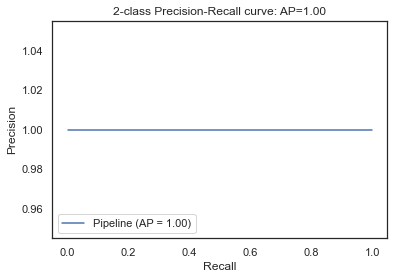

In [43]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, recall_score, precision_score
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_pred,y_test)
f1 = f1_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)

average_precision = average_precision_score(y_test, y_pred)

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"recall: {recall}")
print(f"precision: {precision}")

In [32]:
import pickle

#saving our classifier
with open('random-forest-20-10-2020.pkl', 'wb') as f:
    pickle.dump(clf, f)